# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))

In [2]:
from pkg.robots_custom import *
xcustom = XacroCustomizer()

In [3]:
from enum import Enum
class Scenario(Enum):
    single_object_single_robot = 0
    double_object_single_robot = 1
    single_object_dual_robot = 2
    assembly_3_piece = 3
    custom_robots = 4

In [4]:
current_scenario = Scenario.custom_robots

In [5]:
urdf_content = None
if current_scenario in [Scenario.single_object_dual_robot, Scenario.assembly_3_piece]:
    from pkg.ur10_dual import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_collision_items_dict
elif current_scenario in [Scenario.single_object_single_robot, Scenario.double_object_single_robot]:
    from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_collision_items_dict
else:
    xcustom.clear()
    xcustom.add_robot(RobotType.indy7_robot, xyz=[0,-0.5,0], rpy= [0,0,0])
    xcustom.add_robot(RobotType.panda_robot, xyz=[0,0.5,0], rpy= [0,0,0])
    xcustom.write_xacro()
    JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, urdf_content = \
            xcustom.convert_xacro_to_urdf(joint_fix_dict={'finger':'upper'})
    ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                              0,-np.pi/8,0,-np.pi/2,0,np.pi/2,0])
    xcustom.start_rviz()
    
from pkg.constraint_graph import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True
rospy.init_node('task_planner', anonymous=True)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [6]:
refine_meshes()

In [7]:
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content)
# graph.set_collision_items(collision_items_dict)
# graph.set_collision_items({link:[] for link in LINK_NAMES})

col_items_dict = get_collision_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, 
                                          exclude_link=["panda1_link7"])
graph.set_collision_items(col_items_dict)

[INFO] [1597415174.565416, 175589.290000]: GripperInterface: Waiting for gripper action servers... 
[INFO] [1597415174.820443, 175589.539000]: GripperInterface: Gripper action servers found! 


In [8]:
graph.set_simulation(nWSR=50, regularization_factor= 1e-1)
graph.show_pose(ZERO_JOINT_POSE, execute=True)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


In [9]:
# from pkg.graph_visualize import VisualGraph
# g = VisualGraph()

# # for node, neighbor in graph.node_dict.items(): # for visualizing all
# #     g.add_node(node,neighbor) # for visualizing all

# for node, neighbor in graph.valid_node_dict.items():
#     g.add_node(node,neighbor) # for visualizing all
# g.draw().render()
# g.draw(True)

# Custom Robots

In [10]:
if current_scenario == Scenario.custom_robots:
    collision=True
    graph.add_collision_items("world", 
                              [
                               GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                               GeoBox((0.5,-0.2,0.050), (0.05,0.05,0.05), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision),
                               GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                               GeoBox((0.7,0.0,0.2), (0.7,0.05,0.4), name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                               GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                               GeoBox((0.4,0.4,0.3), (0.1,0.1,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1), collision=False)])
    
    graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,11e-2], link_name="panda1_hand", direction=[0,1,0])
    graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,5e-2], link_name="indy0_tcp", direction=[0,0,1])
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal', _type=PlaceFrame, point=(0.4,0.4,0.3+5e-4), link_name="world", orientation=[0,0,0])

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p","floor"), hexahedral=True)

    graph.update_handles()

# Set RVIZ

In [11]:
graph.set_simulation(nWSR=50, regularization_factor= 1e-1)

publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
graph.show_pose(ZERO_JOINT_POSE, execute=True)

In [13]:
# joint_num = graph.joint_num
# N = 300
# dt = 1e-2

# from_state = State((('box1','bottom_p','floor'),), {'box1': [0.5,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE)
# to_state = State((('box1', 'top_p', 'vac2'), ),None, None)


# e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
# print(succ)

# # e.displayContext()

# end_state_bak = end_state.copy()

# from_state = end_state_bak.copy()
# # from_state.Q = error_pos_list[-7]
# # from_state.Q = [ 0.70884048, -0.57695371, -1.63360349,  0.13754708, -0.48114245,  0.15000046,
# #   0.13899708, -0.10050983, -0.18593015, -1.66651131, -0.3915,      1.6027194,
# #  -0.3915    ]
# to_state = end_state.copy()
# to_state.node = (('box1', 'left_p', 'grip1'),)


# e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)

# # e.displayContext()

# build

In [14]:
graph.build_graph()

# Search Graph (Custom Robots)

In [15]:
if current_scenario == Scenario.custom_robots:
    graph.search_graph_ordered_mp(
        initial_state = State((('box1','bottom_p','floor'),),
                              {'box1': [0.5,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
        goal_state = State((('box1','front_f','goal'),), None, None), display=False,
        search_num=3000, N_agents = 12, expand_depth_on_thread = True, 
        terminate_on_first = True, tree_margin = 4,
        depth_margin = 2, joint_motion_num=10, 
        **dict(N=300, dt=0.01, vel_conv=1e-2, err_conv=5e-4))

start set transition: 	190.0 ms/1 = 190.009 ms 
set_simulate fun: 	4154.0 ms/1 = 4154.499 ms 
post: 	46.0 ms/1 = 46.094 ms 


2. success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 / edepth: 2/2 / 4.72 s (10)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac2'),):(('box1', 'top_p', 'vac2'),)
start set transition: 	379.0 ms/1 = 378.809 ms 
set_simulate fun: 	7077.0 ms/1 = 7077.318 ms 
post: 	0.0 ms/1 = 0.092 ms 


8. fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> / edepth: 2/2 / 9.01 s (4)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'back_p', 'vac2'),):
start set transition: 	158.0 ms/1 = 157.928 ms 
set_simulate fun: 	8364.0 ms/1 = 8364.478 ms 
post: 	61.0 ms/1 = 61.162 ms 


3. fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> / edepth: 2/2 / 9.09 s (11)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'grip1'),):
start set transition: 	257.0 ms/1 = 257.089 ms 
set_simulate fun: 	7790.0 ms/1 = 7789.88 ms 
post: 	0.0 ms/1 = 0.118 ms 

start set transition: 	528.0 ms/2 = 264.12 ms 
set_simulate fun: 	17163.0 ms/2 = 8581.487 ms 
post: 	961.0 ms/2 = 480.488 ms 


17. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 23.46 s (2)
node: (('box1', 'top_p', 'vac2'),)->(('box1', 'top_p', 'vac2'),):
start set transition: 	728.0 ms/2 = 363.864 ms 
set_simulate fun: 	16978.0 ms/2 = 8489.181 ms 
post: 	315.0 ms/2 = 157.402 ms 


19. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 23.58 s (1)
node: (('box1', 'top_p', 'vac2'),)->(('box1', 'top_p', 'vac2'),):
start set transition: 	746.0 ms/2 = 372.762 ms 
set_simulate fun: 	17249.0 ms/2 = 8624.4 ms 
post: 	711.0 ms/2 = 355.387 ms 


21. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 24.44 s (9)
node: (('box1', 'top_p', 'vac2'),)->(('box1', 'top_p', 'vac2'),):
start set transition: 	1397.0 ms/3 = 465.521 ms 
set_simulate fun: 	17044.0 ms/3 = 5681.353 ms 
post: 	744.0 ms/3 = 247.883 ms 


24. success - Goal cost:

start set transition: 	1476.0 ms/4 = 369.059 ms 
set_simulate fun: 	30818.0 ms/4 = 7704.45 ms 
post: 	511.0 ms/4 = 127.721 ms 


39. fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> / edepth: 3/3 / 38.6 s (3)
node: (('box1', 'back_p', 'grip1'),)->(('box1', 'front_f', 'goal'),):
start set transition: 	2217.0 ms/4 = 554.181 ms 
set_simulate fun: 	23709.0 ms/3 = 7903.103 ms 
post: 	385.0 ms/3 = 128.413 ms 


40. success - Goal cost:1->0 / Init cost:1->2 / branching: 7->14 / edepth: 3/3 / 38.77 s (11)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_f', 'goal'),):(('box1', 'front_f', 'goal'),)
stop now!
start set transition: 	1597.0 ms/4 = 399.327 ms 
set_simulate fun: 	27405.0 ms/4 = 6851.318 ms 
post: 	691.0 ms/4 = 172.869 ms 


38. fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> / edepth: 3/3 / 39.31 s (10)
node: (('box1', 'front_p', 'grip1'),)->(('box1', 'front_f', 'goal'),):
start set transition: 	1974.0 ms/4 = 493.574 ms 
set_simulate fun: 	30074.0 ms/4 = 7518.61

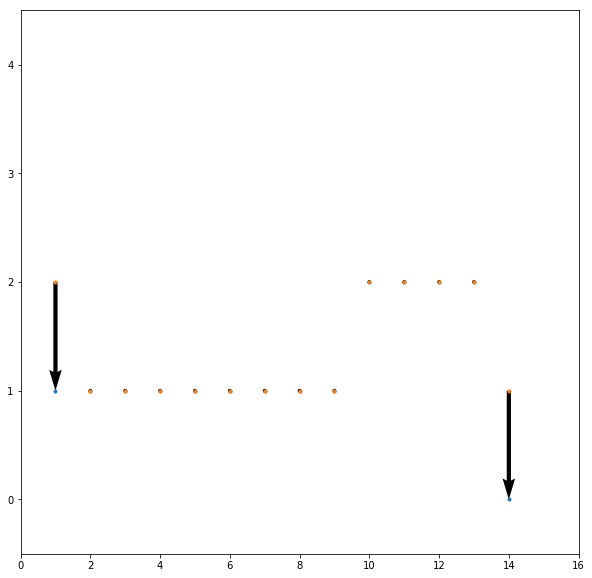

In [16]:
graph.quiver_snodes()

# Replay schedule

In [17]:
schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted, range(len(schedule_sorted))):
    graph.simulate_transition(graph.snode_vec[0].state, graph.snode_vec[0].state, display=True, N=10, dt=0.01, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(1)
#     try:
    e = graph.replay(schedule, execute=True, N=300, dt=0.01, N_step=5, vel_conv=1e-2, err_conv=5e-4)
#     except Exception as e:
#         print(e)

[0, 1, 7, 14]


pkg/utils.py:71: RuntimeWarning: divide by zero encountered in long_scalars
  per_T= np.round(np.sum(self.time_dict[name])/self.count_dict[name], 3),


start set transition: 	0 ms/0 = 0 ms 
post: 	0.0 ms/1 = 0.085 ms 


--------------------
1-(('box1', 'top_p', 'vac2'),)
start set transition: 	0 ms/0 = 0 ms 
post: 	8.0 ms/2 = 4.164 ms 


--------------------
7-(('box1', 'left_p', 'grip1'),)
start set transition: 	0 ms/0 = 0 ms 
post: 	34.0 ms/3 = 11.374 ms 


--------------------
14-(('box1', 'front_f', 'goal'),)
start set transition: 	0 ms/0 = 0 ms 
post: 	50.0 ms/4 = 12.434 ms 



In [18]:
# e = graph.replay(schedule, N=1500, dt=0.002, vel_conv=1e-2, err_conv=5e-3)

In [ ]:
e.displayContext()

# Visualize

In [ ]:
from pkg.graph_visualize import VisualGraph

In [ ]:
g = VisualGraph()

# for node, neighbor in graph.node_dict.items(): # for visualizing all
#     g.add_node(node,neighbor) # for visualizing all

for node, neighbor in graph.valid_node_dict.items():
    g.add_node(node,neighbor) # for visualizing all

# for idx in schedule: # for visualizing schedule
#     snode = graph.snode_vec[idx]
#     leafs = [(leaf, graph.snode_vec[leaf]) for leaf in snode.leafs if leaf in schedule] # for visualizing schedule
#     g.add_node("%d-"%idx+str(snode.state.node),["%d-"%i_l+str(leaf.state.node) for i_l, leaf in leafs]) # for visualizing schedule

In [ ]:
g.draw().render()
g.draw(True)

# delete all

In [ ]:
for mkr in marker_list:
    mkr.delete()

# Plotting (using the Bokeh library to provide interactive plots)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from etasl_py.bokehplots import plotv

output_notebook()
print("positions : ")
plotv(e.TIME,e.POS,e.POS_LBL)
print("velocities : ")
plotv(e.TIME,e.VEL,e.POS_LBL)
print("outputs : ")
plotv(e.TIME,e.OUTP,e.OUTP_LBL)

In [ ]:
!urdf_to_graphiz $(rospack find etasl_py_examples)/robots/ur10_robot.urdf
from graphviz import Source
Source.from_file('ur10.gv')